# Libraries

In [1]:
import random

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Subset
from torch.optim import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import torch_geometric as pyg
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

/home/leffff/PycharmProjects/misis-ai-course-final-project-2023/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        # torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        


In [3]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class TrainingConfig:
    # Training
    batch_size = 2048
    epochs = 50
    learning_rate = 1e-2
    lr_warmup_steps = 500

    device = "cuda"
    random_state = 42


config = TrainingConfig()
seed_everything(config.random_state)

# Data

In [4]:
df = pd.read_excel("data/19_35000.xlsx", index_col=0).reset_index(drop=True)
df

,Title,IC50,SMILES
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...,...
36372,CHEMBL3699085,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,CHEMBL2259758,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


In [5]:
perc_99 = np.percentile(df["IC50"], 99)
df = df[df["IC50"] <= perc_99]

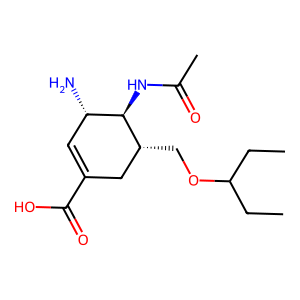

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw

m = Chem.MolFromSmiles(df["SMILES"].tolist()[1])
img = Draw.MolToImage(m)
img

In [7]:
x = pyg.utils.smiles.from_smiles(df["SMILES"].tolist()[1])

In [8]:
class MolDataset(Dataset):
    def __init__(self, df):
        super(MolDataset, self).__init__()
        self.smiles = df["SMILES"].tolist()
        self.target = df["IC50"].tolist()
        
    def __len__(self):
        return len(self.smiles)
        
        
    def __getitem__(self, idx):
        x = pyg.utils.smiles.from_smiles(self.smiles[idx])
        return x, self.target[idx]

In [9]:
train_inds, test_inds = train_test_split(np.arange(df.shape[0]))
train_inds

array([14264, 22771, 18773, ..., 11284,   860, 15795])

In [10]:
dataset = MolDataset(df)

train_loader = DataLoader(
    Subset(dataset, train_inds),
    shuffle=True,
    batch_size=config.batch_size
)

eval_loader = DataLoader(
    Subset(dataset, test_inds),
    shuffle=True,
    batch_size=config.batch_size
)

/home/leffff/PycharmProjects/misis-ai-course-final-project-2023/.venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
# all_node_features = []
# all_edge_features = []

# for i in tqdm(range(len(dataset))):
#     all_node_features.append(dataset[i][0].x)
#     all_edge_features.append(dataset[i][0].edge_attr)

# all_node_features = torch.cat(all_node_features, dim=0)
# all_edge_features = torch.cat(all_edge_features, dim=0)

In [12]:
# all_node_features.shape

In [13]:
# for i in range(9):
#     print(all_node_features[:, i].unique(return_counts=True))

# Model

In [14]:
class RegresisionGNN(torch.nn.Module):
    def __init__(self, backbone, backbone_dim, pooling_f=global_mean_pool):
        super(RegresisionGNN, self).__init__()
        self.backbone = backbone
        self.pooling = pooling_f
        self.out = pyg.nn.Linear(backbone_dim, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x.float(), data.edge_index, data.edge_attr.float(), data.batch
        node_features = self.backbone(
            x=x, 
            edge_index=edge_index, 
            edge_attr=edge_attr
        )

        batch_features = self.pooling(node_features, batch)
        
        return self.out(batch_features)


backbone = pyg.nn.models.GCN(in_channels=9, hidden_channels=64, num_layers=4, out_channels=32)
model = RegresisionGNN(backbone, 32)
model

RegresisionGNN(
  (backbone): GCN(9, 32, num_layers=4)
  (out): Linear(32, 1, bias=True)
)

In [15]:
optimizer = AdamW(model.parameters(), lr=config.learning_rate)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_loader) * config.epochs),
)

loss_function = torch.nn.L1Loss()

# Let's Train

In [16]:
def train_epoch(model, loader, loss_function, optimizer, scheduler, device):
    model.train()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        data, y = batch
        data, y = data.to(device), y.to(device)
        output = model(data)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).sigmoid().detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"TRAIN Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}
        
        
def eval_epoch(model, loader, loss_function, device):
    model.eval()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        data, y = batch
        data, y = data.to(device), y.to(device)
        
        with torch.no_grad():
            output = model(data)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).sigmoid().detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"EVAL Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}

In [17]:
train_logs, eval_logs = [], []

for i in range(config.epochs):
    train_log = train_epoch(
        model=model, 
        loader=train_loader, 
        loss_function=loss_function, 
        optimizer=optimizer,
        scheduler=scheduler,
        device=config.device
    )
    
    eval_log = eval_epoch(
        model=model, 
        loader=eval_loader, 
        loss_function=loss_function, 
        device=config.device
    )

    print(train_log, eval_log)
    
    train_logs.append(train_log)
    eval_logs.append(eval_log)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


{'TRAIN Loss': {5.345518384660993}, 'MAE': {4.575929641723633}, 'R2': -0.3664116670071358} {'EVAL Loss': {4.958343410491944}, 'MAE': {4.467462062835693}, 'R2': -0.3696187693059303}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


{'TRAIN Loss': {4.398544584001813}, 'MAE': {4.383393287658691}, 'R2': -0.32939438367897456} {'EVAL Loss': {3.790942144393921}, 'MAE': {4.2087836265563965}, 'R2': -0.3160650320128948}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


{'TRAIN Loss': {3.3698843206678117}, 'MAE': {4.167403221130371}, 'R2': -0.28652088433974954} {'EVAL Loss': {3.2329206466674805}, 'MAE': {4.094083309173584}, 'R2': -0.2912167500142051}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


{'TRAIN Loss': {3.204446962901524}, 'MAE': {4.128701686859131}, 'R2': -0.27850291139979166} {'EVAL Loss': {3.2087300300598143}, 'MAE': {4.112764835357666}, 'R2': -0.29532600352621086}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


{'TRAIN Loss': {3.178719231060573}, 'MAE': {4.132200717926025}, 'R2': -0.27920721887119826} {'EVAL Loss': {3.220199632644653}, 'MAE': {4.108953952789307}, 'R2': -0.29447279785319114}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.217382158551897}, 'MAE': {4.133031845092773}, 'R2': -0.2793721612168094} {'EVAL Loss': {3.1269570350646974}, 'MAE': {4.106692314147949}, 'R2': -0.29395413190714237}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


{'TRAIN Loss': {3.183950798852103}, 'MAE': {4.132671356201172}, 'R2': -0.27927434669906703} {'EVAL Loss': {3.1456911087036135}, 'MAE': {4.101070880889893}, 'R2': -0.2926952847744482}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


{'TRAIN Loss': {3.1879636560167586}, 'MAE': {4.13166618347168}, 'R2': -0.2790285789343263} {'EVAL Loss': {3.1373468399047852}, 'MAE': {4.101622581481934}, 'R2': -0.29278986510081895}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


{'TRAIN Loss': {3.150497078895569}, 'MAE': {4.132604598999023}, 'R2': -0.27920590506182696} {'EVAL Loss': {3.139382553100586}, 'MAE': {4.104541778564453}, 'R2': -0.29339219022314}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {3.1466177872249057}, 'MAE': {4.13188362121582}, 'R2': -0.27902499547355286} {'EVAL Loss': {3.102760171890259}, 'MAE': {4.108142852783203}, 'R2': -0.2941322968925826}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {3.1913128920963834}, 'MAE': {4.132103443145752}, 'R2': -0.27904388261692525} {'EVAL Loss': {3.16287522315979}, 'MAE': {4.1027374267578125}, 'R2': -0.29296190599648697}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


{'TRAIN Loss': {3.160828913961138}, 'MAE': {4.132338047027588}, 'R2': -0.2790941526036812} {'EVAL Loss': {3.1515199184417724}, 'MAE': {4.100160598754883}, 'R2': -0.29239972904739786}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


{'TRAIN Loss': {3.173071963446481}, 'MAE': {4.132154941558838}, 'R2': -0.27903746443844346} {'EVAL Loss': {3.1428550243377686}, 'MAE': {4.100889205932617}, 'R2': -0.2925348043253957}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {3.177392074040004}, 'MAE': {4.131958484649658}, 'R2': -0.2789769112037812} {'EVAL Loss': {3.094251012802124}, 'MAE': {4.105137348175049}, 'R2': -0.293402963969446}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {3.189871975353786}, 'MAE': {4.132364273071289}, 'R2': -0.27904033209890144} {'EVAL Loss': {3.1039751529693604}, 'MAE': {4.102993011474609}, 'R2': -0.2929248877919539}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {3.1530405282974243}, 'MAE': {4.132471084594727}, 'R2': -0.27904379448320227} {'EVAL Loss': {3.1771658420562745}, 'MAE': {4.1003098487854}, 'R2': -0.2923778294973951}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {3.1684706892286028}, 'MAE': {4.13150691986084}, 'R2': -0.278874145646657} {'EVAL Loss': {3.180552101135254}, 'MAE': {4.114372253417969}, 'R2': -0.2952632278605134}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {3.1882920265197754}, 'MAE': {4.13530969619751}, 'R2': -0.27958816632694106} {'EVAL Loss': {3.181294345855713}, 'MAE': {4.099318027496338}, 'R2': -0.2921859784235674}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {3.1572539806365967}, 'MAE': {4.131688594818115}, 'R2': -0.2789234769395059} {'EVAL Loss': {3.1836480617523195}, 'MAE': {4.108902931213379}, 'R2': -0.29416280755763546}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.1582878146852766}, 'MAE': {4.133001327514648}, 'R2': -0.2791713145407231} {'EVAL Loss': {3.1760080814361573}, 'MAE': {4.098296642303467}, 'R2': -0.2919416001126789}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {3.1156236614499773}, 'MAE': {4.132292747497559}, 'R2': -0.2790004198696501} {'EVAL Loss': {3.1436559200286864}, 'MAE': {4.108675956726074}, 'R2': -0.29408348396770534}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {3.142172932624817}, 'MAE': {4.132868766784668}, 'R2': -0.2791307121426463} {'EVAL Loss': {3.240772914886475}, 'MAE': {4.113609313964844}, 'R2': -0.2950858211075722}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {3.157055752617972}, 'MAE': {4.133138656616211}, 'R2': -0.2791999203039437} {'EVAL Loss': {3.1243268966674806}, 'MAE': {4.102097511291504}, 'R2': -0.29274378610797713}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {3.1326552288872853}, 'MAE': {4.1324310302734375}, 'R2': -0.2790457579550909} {'EVAL Loss': {3.130165433883667}, 'MAE': {4.099815845489502}, 'R2': -0.2922366444111888}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.1534312963485718}, 'MAE': {4.133085250854492}, 'R2': -0.27914232034219544} {'EVAL Loss': {3.115203285217285}, 'MAE': {4.1054487228393555}, 'R2': -0.2934179038743754}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {3.138723986489432}, 'MAE': {4.132355213165283}, 'R2': -0.279036030969936} {'EVAL Loss': {3.1537044048309326}, 'MAE': {4.103634834289551}, 'R2': -0.29304340882924196}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.1822036845343455}, 'MAE': {4.132179260253906}, 'R2': -0.2790024681624319} {'EVAL Loss': {3.090951681137085}, 'MAE': {4.102982044219971}, 'R2': -0.2928941158230398}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.168991037777492}, 'MAE': {4.132163047790527}, 'R2': -0.27897328860498294} {'EVAL Loss': {3.1285074234008787}, 'MAE': {4.107706546783447}, 'R2': -0.2938063735041758}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.175851379122053}, 'MAE': {4.13263463973999}, 'R2': -0.2790565238581768} {'EVAL Loss': {3.1864167213439942}, 'MAE': {4.1202802658081055}, 'R2': -0.29638244551756765}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.237938949040004}, 'MAE': {4.136296272277832}, 'R2': -0.2798843316168591} {'EVAL Loss': {3.140896511077881}, 'MAE': {4.110142707824707}, 'R2': -0.2945265710277256}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {3.181889125279018}, 'MAE': {4.133863925933838}, 'R2': -0.2793815762418115} {'EVAL Loss': {3.1584182739257813}, 'MAE': {4.097222328186035}, 'R2': -0.29176612658389645}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.137794954436166}, 'MAE': {4.131469249725342}, 'R2': -0.2789052201115598} {'EVAL Loss': {3.1742024421691895}, 'MAE': {4.1174092292785645}, 'R2': -0.2959148734667043}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


{'TRAIN Loss': {3.1867697749819075}, 'MAE': {4.135763168334961}, 'R2': -0.2796694039522767} {'EVAL Loss': {3.2280412197113035}, 'MAE': {4.096411228179932}, 'R2': -0.2916081415011924}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


{'TRAIN Loss': {3.2405896186828613}, 'MAE': {4.132289886474609}, 'R2': -0.27909621217757774} {'EVAL Loss': {3.0763949871063234}, 'MAE': {4.104813098907471}, 'R2': -0.29332101279382083}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


{'TRAIN Loss': {3.1729033844811574}, 'MAE': {4.132031440734863}, 'R2': -0.2789463048300347} {'EVAL Loss': {3.1216225147247316}, 'MAE': {4.100440502166748}, 'R2': -0.2923457200234316}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


{'TRAIN Loss': {3.144194483757019}, 'MAE': {4.132936954498291}, 'R2': -0.2790993075895958} {'EVAL Loss': {3.142741823196411}, 'MAE': {4.097364902496338}, 'R2': -0.2917539764197472}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


{'TRAIN Loss': {3.1933079787663052}, 'MAE': {4.137278079986572}, 'R2': -0.2800206275189563} {'EVAL Loss': {3.224686622619629}, 'MAE': {4.094415664672852}, 'R2': -0.2911933087221572}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


{'TRAIN Loss': {3.193022574697222}, 'MAE': {4.131103038787842}, 'R2': -0.27886623551188805} {'EVAL Loss': {3.1546331882476806}, 'MAE': {4.0993828773498535}, 'R2': -0.2921806516839933}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


{'TRAIN Loss': {3.1758927617754256}, 'MAE': {4.131484508514404}, 'R2': -0.27885505320070836} {'EVAL Loss': {3.1113385200500487}, 'MAE': {4.107718467712402}, 'R2': -0.2938198078623886}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {3.1336066722869873}, 'MAE': {4.132669448852539}, 'R2': -0.27906605669357143} {'EVAL Loss': {3.2032840728759764}, 'MAE': {4.123854637145996}, 'R2': -0.2971289162496178}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.1745602914265225}, 'MAE': {4.1375041007995605}, 'R2': -0.2801239883132103} {'EVAL Loss': {3.1878172397613525}, 'MAE': {4.095829486846924}, 'R2': -0.29148245477189416}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {3.175479139600481}, 'MAE': {4.133670330047607}, 'R2': -0.27932880267058313} {'EVAL Loss': {3.153404951095581}, 'MAE': {4.100459575653076}, 'R2': -0.2924416827852472}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {3.163265585899353}, 'MAE': {4.130979061126709}, 'R2': -0.2788166798325211} {'EVAL Loss': {3.114810419082642}, 'MAE': {4.10788631439209}, 'R2': -0.29401691765907856}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.1421696628843034}, 'MAE': {4.132235527038574}, 'R2': -0.27909622736011763} {'EVAL Loss': {3.1267940044403075}, 'MAE': {4.107566833496094}, 'R2': -0.29386932847938674}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


{'TRAIN Loss': {3.14346216406141}, 'MAE': {4.132747650146484}, 'R2': -0.27913459860079515} {'EVAL Loss': {3.1269211292266847}, 'MAE': {4.102831840515137}, 'R2': -0.2928570261735344}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


{'TRAIN Loss': {3.1521435294832503}, 'MAE': {4.131410598754883}, 'R2': -0.2788258049533492} {'EVAL Loss': {3.174146795272827}, 'MAE': {4.106197357177734}, 'R2': -0.2935020478349115}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.17622743334089}, 'MAE': {4.131856918334961}, 'R2': -0.2789304673130606} {'EVAL Loss': {3.104843521118164}, 'MAE': {4.102901935577393}, 'R2': -0.29286594699109725}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.1276573623929704}, 'MAE': {4.13211727142334}, 'R2': -0.27898457908347263} {'EVAL Loss': {3.1685879230499268}, 'MAE': {4.103428840637207}, 'R2': -0.2929575581806312}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {3.176966428756714}, 'MAE': {4.131802558898926}, 'R2': -0.27892674482038404} {'EVAL Loss': {3.1611608028411866}, 'MAE': {4.104648590087891}, 'R2': -0.29319928257967964}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]

{'TRAIN Loss': {3.1185233763286044}, 'MAE': {4.132709980010986}, 'R2': -0.2791001641906048} {'EVAL Loss': {3.17292799949646}, 'MAE': {4.104213237762451}, 'R2': -0.29311168783284036}
